In [2]:
import os
import numpy as np
import imageio
from scipy import ndimage
import skimage.morphology
import matplotlib.pyplot as plt
import pdb
from numpy import mgrid, sum
from skimage import img_as_float
import cv2
from scipy import signal

# Problem 1

In [38]:
origin_Im = imageio.imread(os.path.join("aerobic-001.bmp"))
# test with different thresholds
thresholds =[5,10,15,20]
for threshold in thresholds:
      os.makedirs("threshold{:d}".format(threshold),exist_ok=True)
for i in range(1, 22):
      im = imageio.imread(os.path.join("aerobic-{}.bmp".format(str(i + 1).zfill(3))))
      for threshold in thresholds:
          diff = abs(im - origin_Im) >= threshold
          diff = ndimage.binary_opening(diff, structure=np.ones((3, 3)))
          #remove any tiny regions
          diff = skimage.morphology.remove_small_objects(diff, min_size=55, connectivity=1, in_place=False)
          diff = diff.astype(np.uint8) * 255
          imageio.imwrite(os.path.join("threshold{:d}".format(threshold),"diff-{:03}.bmp".format(i + 1)),diff)


Discussion:

For the problem 1, I expreiment thresholds 5, 10, 15, and 20. I first create new folders which are named threshold#.And the outputs will be saved in each folder. 

# Problem2

In [8]:
def similitudeMoments(image):
    # Normalize grayscale image
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    x, y = mgrid[:image.shape[0],:image.shape[1]]
    
    ## initial
    moments = {}
    Nvals ={}
    
    #x bar and y bar
    moments['x_'] = sum(x*image)/sum(image)
    moments['y_'] = sum(y*image)/sum(image)
    
    # Spatial moments
    moments['m00'] = sum(image)

    moments['m01'] = sum(x*image)
    moments['m10'] = sum(y*image)
    moments['m11'] = sum(y*x*image)
    moments['m02'] = sum(x**2*image)
    moments['m20'] = sum(y**2*image)
    moments['m12'] = sum(x*y**2*image)
    moments['m21'] = sum(x**2*y*image)
    moments['m03'] = sum(x**3*image)
    moments['m30'] = sum(y**3*image)
    
    #Central moments
    
    moments['mu01']= sum((y-moments['y_'])*image)
    moments['mu10']= sum((x-moments['x_'])*image)
    moments['mu11'] = sum((x-moments['x_'])*(y-moments['y_'])*image)
    moments['mu02'] = sum((y-moments['y_'])**2*image)
    moments['mu20'] = sum((x-moments['x_'])**2*image)
    moments['mu12'] = sum((x-moments['x_'])*(y-moments['y_'])**2*image)
    moments['mu21'] = sum((x-moments['x_'])**2*(y-moments['y_'])*image)
    moments['mu03'] = sum((y-moments['y_'])**3*image)
    moments['mu30'] = sum((x-moments['x_'])**3*image)
    
    # Similitude Moments
    Nvals['n02'] = moments['mu02'] / sum(image)**(2/2+1)
    Nvals['n03'] = moments['mu03'] / sum(image)**(3/2+1)
    Nvals['n11'] = moments['mu11'] / sum(image)**(2/2+1)
    Nvals['n12'] = moments['mu12'] / sum(image)**(3/2+1)
    Nvals['n20'] = moments['mu20'] / sum(image)**(2/2+1)
    Nvals['n21'] = moments['mu21'] / sum(image)**(3/2+1)
    Nvals['n30'] = moments['mu30'] / sum(image)**(3/2+1)
    
    return Nvals

<ipython-input-37-b70d1bd2fe92>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  MEI = np.zeros_like(diffs[0]).astype(np.bool)


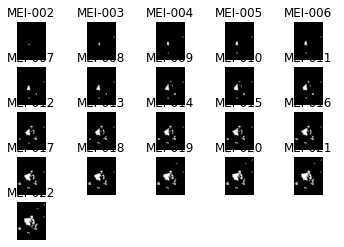

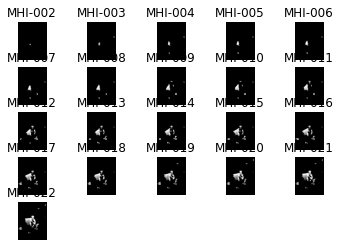

MEI:  {'n02': 0.28693331357522245, 'n03': 0.019277681430337135, 'n11': -0.08129223245325587, 'n12': -0.007257769551763045, 'n20': 0.2714689182454791, 'n21': 0.08384699796334377, 'n30': -0.052502394809815424}
MHI:  {'n02': 0.3523762053571009, 'n03': -0.02752167545187336, 'n11': -0.1113495009648582, 'n12': 0.005223465673085032, 'n20': 0.3314530407368646, 'n21': 0.11516437305322302, 'n30': -0.0992379591554864}


In [37]:
diffs = []
for i in range(1, 22):
    diff = imageio.imread(os.path.join("threshold20","diff-{}.bmp".format(str(i + 1).zfill(3))))
    diff = diff > 20
    diffs.append(diff)

figure, axs = plt.subplots(5,5)
#compute MEI
MEI = np.zeros_like(diffs[0]).astype(np.bool)
for i in range(0, 21):
    MEI = MEI + diffs[i]
    axs[i // 5, i % 5].set_title("MEI-{:03d}".format(i + 2))
    axs[i // 5, i % 5].axis("off")
    axs[i // 5, i % 5].imshow(MEI.astype(np.uint8) * 255, cmap="gray")
for i in range(21, 25):
    axs[i // 5, i % 5].axis("off")

plt.show()

figure, axs = plt.subplots(5, 5)

#compute MHI 
MHI_prev = np.zeros_like(diffs[0]).astype(np.float32)
for i in range(0, 21):
    MHI = np.zeros_like(MHI_prev)
    MHI[MHI_prev > 0] = MHI_prev[MHI_prev > 0] - 1.
    MHI[diffs[i]] = 22
    MHI_prev = MHI
    axs[i // 5, i % 5].set_title("MHI-{:03d}".format(i + 2))
    axs[i // 5, i % 5].axis("off")
    axs[i // 5, i % 5].imshow((MHI / 22 * 255).astype(np.uint8), cmap="gray")

for i in range(21, 25):
    axs[i // 5, i % 5].axis("off")

plt.show()

MEI_similitudeMoments = similitudeMoments(MEI.astype(np.float32))
print("MEI: ", MEI_similitudeMoments)
MHI_similitudeMoments = similitudeMoments(MHI.astype(np.float32) / 22)
print("MHI: ", MHI_similitudeMoments)

Discussion:


For this problem, the input I usedw is in the folder: threshold20 which was created in the problem 1. 

# Problem3

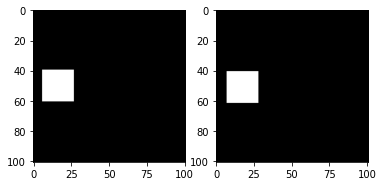

In [35]:
# Create the first image 
img1 = np.zeros((101, 101), dtype=np.float32)
img1[40:61, 6:27] = 1

# Create the second image
img2 = np.zeros((101, 101), dtype=np.float32)
img2[41:62, 7:28] = 1

plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')

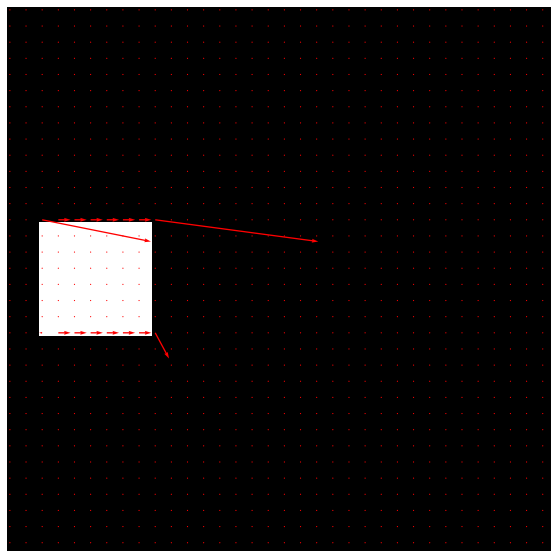

In [40]:
fx = (signal.convolve2d(img1, np.fliplr(0.25 * np.array([[-1., 1.], [-1., 1.]])), boundary='symm', mode='same'))
fy = (signal.convolve2d(img1, 0.25 * np.array([[-1., -1.], [1., 1.]]), boundary='symm', mode='same'))
ft = (signal.convolve2d(img2, 0.25 * np.array([[1., 1.], [1., 1.]]), boundary='symm', mode='same') + 
         signal.convolve2d(img1, -0.25 * np.array([[1., 1.], [1., 1.]]), boundary='symm', mode='same'))
    
u = np.zeros(img1.shape)
v = np.zeros(img1.shape)
    
window = np.ones((3,3))
    
denom = (signal.convolve2d(fx**2, window, boundary='symm', mode='same') * 
            signal.convolve2d(fy**2, window, boundary='symm', mode='same') -
            signal.convolve2d(fx*fy, window, boundary='symm', mode='same')**2)
denom[denom == 0] = 1
    
u = ((signal.convolve2d(fy**2, window, boundary='symm', mode='same') * 
             signal.convolve2d(fy*ft, window, boundary='symm', mode='same') + 
             signal.convolve2d(fx*fy, window, boundary='symm', mode='same') * 
             signal.convolve2d(fy*ft, window, boundary='symm', mode='same') ) /
        denom)
    
    
v = ((signal.convolve2d(fx*ft, window, boundary='symm', mode='same') * 
             signal.convolve2d(fx*fy, window, boundary='symm', mode='same') -
             signal.convolve2d(fx**2, window, boundary='symm', mode='same') * 
             signal.convolve2d(fy*ft, window, boundary='symm', mode='same')) / 
        denom)
    
# Draw the motion vectors on the image
x, y = np.meshgrid(np.arange(0, img1.shape[1], 1), np.arange(0, img1.shape[0], 1))
plt.figure(figsize=(10,10))
plt.imshow(img1, cmap='gray')
plt.quiver(x[::3, ::3], y[::3, ::3], u[::3,::3], v[::3,::3], color='red', scale=25)
plt.axis("off")
plt.show()

Discussion:

To be honest, this result is not what I expected. This is because I notice it seems something wrong with the those three arrow in the coners. But I am not sure why there missing a arrow at the left-bottom coner. 